## 1. Setup and Import libraries

In [66]:
# django path
mysite_path = "C:\\Data\\UCL\\@MSc Project\\DB\\mysite\\"

In [67]:
# standard packages
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import django
from set_django_db import set_django_db
from asgiref.sync import sync_to_async

from IPython.core.display import HTML

%matplotlib inline

In [68]:
# set django models
set_django_db(mysite_path)
from tables_daniel.models import Company, Review

# specifically for Jupyter notebooks
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [69]:
# set pandas display
pd.set_option('display.max_rows', 100)

In [70]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical_align: middle;
}
</style>
""")

## 2. Filter companies (+reviews) listed on S&P 500

### 2.1 Load the data

#### 2.1.1 Companies

In [71]:
companies = pd.DataFrame(
    list(
        Company
        .objects
        .values('id', 'Company', 'Country', 'Sector', 'Industry', 'NoEmployees', 'Revenue')
        .all()
        .filter(ListedOn='S&P 500')
    )
)

In [72]:
companies['TotalReviews'] = 0

def sumReviews(row):
    try:
        return len(
            list(
                Review
                .objects
                .all()
                .filter(Company=companies.loc[row, 'id'])
            )
        )
    except:
        return 0


for row in range(companies.shape[0]):
    companies.loc[row, 'TotalReviews'] = sumReviews(row)

In [73]:
companies

,id,Company,Country,Sector,Industry,NoEmployees,Revenue,TotalReviews
0,51,3M Company,3M Center,Industrials,Specialty Industrial Machinery,96163,32348000.0,0
1,52,Abbott Laboratories,United States,Healthcare,Medical Devices,107000,32095000.0,830
2,53,AbbVie Inc.,United States,Healthcare,Drug Manufacturers—General,30000,34057000.0,300
3,54,ABIOMED Inc,United States,Healthcare,Medical Devices,1536,840883.0,60
4,55,Accenture plc,Grand Canal Harbour,Technology,Information Technology Services,513000,43274244.0,1040
...,...,...,...,...,...,...,...,...
495,546,Yum! Brands Inc,United States,Consumer Cyclical,Restaurants,34000,5606000.0,70
496,547,Zebra Technologies,United States,Technology,Communication Equipment,8200,4471000.0,150
497,548,Zimmer Biomet Holdings,United States,Healthcare,Medical Devices,19900,7790500.0,240
498,549,Zions Bancorp,One South Main Street,Financial Services,Banks—Regional,9879,2808000.0,100


#### 2.1.2 Reviews

In [74]:
companies_id = list(companies.id)

In [75]:
reviews = list(
    Review
    .objects
    .values('Company_id', 'ReviewTitle', 'Rating', 'Pros', 'Cons', 'Year', 'Month', 'Day',
            'JobTitle', 'EmployeeRelationship')
    .all()
    .filter(Company_id = company_id) for company_id in companies_id
)

In [76]:
reviews_df = pd.DataFrame(
    sum([list(reviews_i) for reviews_i in reviews],[])
)

print(reviews_df.shape)


#########
reviews_df = reviews_df.drop_duplicates()
print(reviews_df.shape)

(346083, 10)
(345634, 10)


In [77]:
reviews_df.head()

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer


### 2.2 DF transformation

Add some useful columns

In [78]:
reviews_df = reviews_df.merge(
    companies[['id', 'Company', 'Sector']].rename(columns={'id': 'Company_id',
                                                           'Company': 'Company',
                                                           'Sector': 'Sector'                                                 
                                                }),
    on='Company_id'
)

In [79]:
reviews_df['Date'] = reviews_df.apply(lambda x: '-'.join(
    [str(x['Year']), str(x['Month']), str(x['Day'])]
    ), axis=1
)

reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator,Abbott Laboratories,Healthcare,2020-7-9
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate,Abbott Laboratories,Healthcare,2020-7-6
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA,Abbott Laboratories,Healthcare,2020-7-6
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer,Abbott Laboratories,Healthcare,2020-7-5
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer,Abbott Laboratories,Healthcare,2020-7-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345629,550,Your boss is the make or break,2.0,"Scientific innovation, plenty of resources, go...",There are many good people who work for this c...,2018,6,3,Current Employee,Senior Scientist,Zoetis,Healthcare,2018-6-3
345630,550,Intercompany supply coordinator,3.0,"Flexible working hours, co workers, coffee","contract type, possibility to grow",2018,5,30,Current Employee,Intercompany Supply Coordinator,Zoetis,Healthcare,2018-5-30
345631,550,Manager,3.0,"Great benefits, flexible hours and gender equa...",Very hierarchy oriented. Some leadership treat...,2018,5,28,Current Employee,Anonymous Employee,Zoetis,Healthcare,2018-5-28
345632,550,Director,1.0,Good pay; Good health benefits; cafeteria is g...,This is the worst company I’ve ever worked for...,2018,5,28,Former Employee,Director,Zoetis,Healthcare,2018-5-28


In [80]:
def string_to_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')
    
def string_to_YM(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')

reviews_df['Date'] = reviews_df['Date'].apply(lambda x: string_to_date(x))

reviews_df['Year-Month'] = reviews_df.apply(lambda x: string_to_YM('-'.join([str(x['Year']), str(x['Month'])])), axis=1)

In [81]:
reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date,Year-Month
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator,Abbott Laboratories,Healthcare,2020-07-09,2020-07-01
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate,Abbott Laboratories,Healthcare,2020-07-06,2020-07-01
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA,Abbott Laboratories,Healthcare,2020-07-06,2020-07-01
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer,Abbott Laboratories,Healthcare,2020-07-05,2020-07-01
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer,Abbott Laboratories,Healthcare,2020-07-04,2020-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345629,550,Your boss is the make or break,2.0,"Scientific innovation, plenty of resources, go...",There are many good people who work for this c...,2018,6,3,Current Employee,Senior Scientist,Zoetis,Healthcare,2018-06-03,2018-06-01
345630,550,Intercompany supply coordinator,3.0,"Flexible working hours, co workers, coffee","contract type, possibility to grow",2018,5,30,Current Employee,Intercompany Supply Coordinator,Zoetis,Healthcare,2018-05-30,2018-05-01
345631,550,Manager,3.0,"Great benefits, flexible hours and gender equa...",Very hierarchy oriented. Some leadership treat...,2018,5,28,Current Employee,Anonymous Employee,Zoetis,Healthcare,2018-05-28,2018-05-01
345632,550,Director,1.0,Good pay; Good health benefits; cafeteria is g...,This is the worst company I’ve ever worked for...,2018,5,28,Former Employee,Director,Zoetis,Healthcare,2018-05-28,2018-05-01


## 3. Company exploration

### 3.1 Companies and reviews per sector

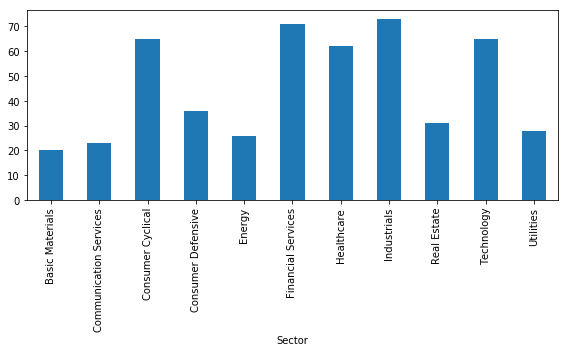

In [82]:
plt.figure(figsize=(8,5))

(companies
 .groupby('Sector')
 .count()
 .id
 .plot
 .bar()
)

#plt.ylim(top)

plt.tight_layout()

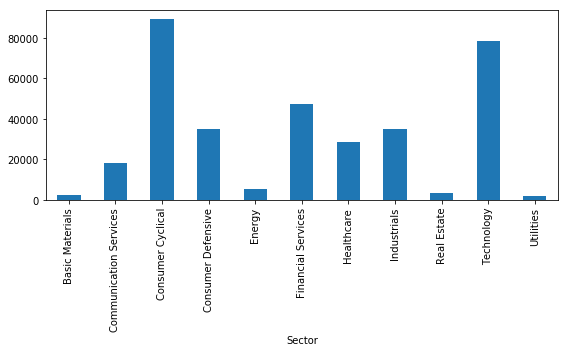

In [83]:
plt.figure(figsize=(8,5))

(reviews_df
 .groupby('Sector')
 .count()
 .Company_id
 .plot
 .bar()
)

plt.tight_layout()

In [86]:
# further analysis focusing only on the companies with at least 10 reviews in the monitored period
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

reviews_bySector = pd.DataFrame(reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
 .groupby(['Company'])
 .Rating
 .agg(['count'])
)

reviews_bySector = pd.DataFrame(reviews_bySector.to_records())

companies['newCount'] = 0

for row in range(reviews_bySector.shape[0]):
    company, count = reviews_bySector.iloc[row,]['Company'], reviews_bySector.iloc[row,]['count']
    ind = companies[companies.Company==company].index
    companies.loc[ind, 'newCount'] = count

(companies[companies.newCount>10]
 .groupby('Sector')
 .count()
 .id
)

Sector
Basic Materials           18
Communication Services    20
Consumer Cyclical         63
Consumer Defensive        36
Energy                    23
Financial Services        70
Healthcare                61
Industrials               69
Real Estate               23
Technology                64
Utilities                 25
Name: id, dtype: int64

### 3.2 Companies per industry

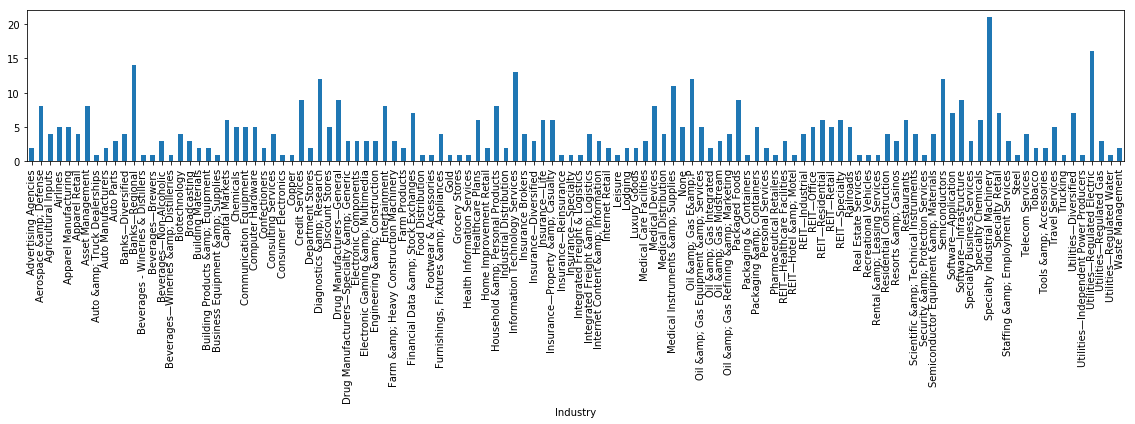

In [23]:
plt.figure(figsize=(16,6))

(companies
 .groupby('Industry')
 .count()
 .id
 .plot
 .bar()
)

plt.ylim

plt.tight_layout()

## 4. Review/ratings exploration

In [71]:
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

### 4.1 Mean rating - per month & sector

In [72]:
reviews_MonthSector = pd.DataFrame(reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
 .groupby(['Sector', 'Year-Month'])
 .agg(['count', 'mean'])
)

reviews_MonthSector = pd.DataFrame(
    reviews_MonthSector.to_records()
)[['Sector', 'Year-Month', "('Rating', 'mean')", "('Rating', 'count')"]]

reviews_MonthSector.columns = ['Sector', 'Year-Month', 'Rating', 'Count']

In [79]:
# add sector to the DF
sectors = reviews_MonthSector.Sector.unique()

# add 3-month rating average to the DF
reviews_MonthSector['3M_Average']=0
i=0

for sector in sectors:
    avg = reviews_MonthSector[reviews_MonthSector.Sector==sector].Rating.rolling(window=3).mean()
    
    start = i
    end = i+avg.shape[0]
    reviews_MonthSector.iloc[start:end, -1] = avg
    
    i+=avg.shape[0]

In [80]:
reviews_MonthSector

,Sector,Year-Month,Rating,Count,3M_Average
0,Basic Materials,2018-07-01,3.560606,132,NaN
1,Basic Materials,2018-08-01,3.521739,115,NaN
2,Basic Materials,2018-09-01,3.636364,88,3.572903
3,Basic Materials,2018-10-01,3.366337,101,3.508146
4,Basic Materials,2018-11-01,3.533981,103,3.512227
...,...,...,...,...,...
283,Utilities,2020-02-01,3.616438,73,3.592662
284,Utilities,2020-03-01,3.716418,67,3.716316
285,Utilities,2020-04-01,3.931818,44,3.754891
286,Utilities,2020-05-01,3.575758,66,3.741331


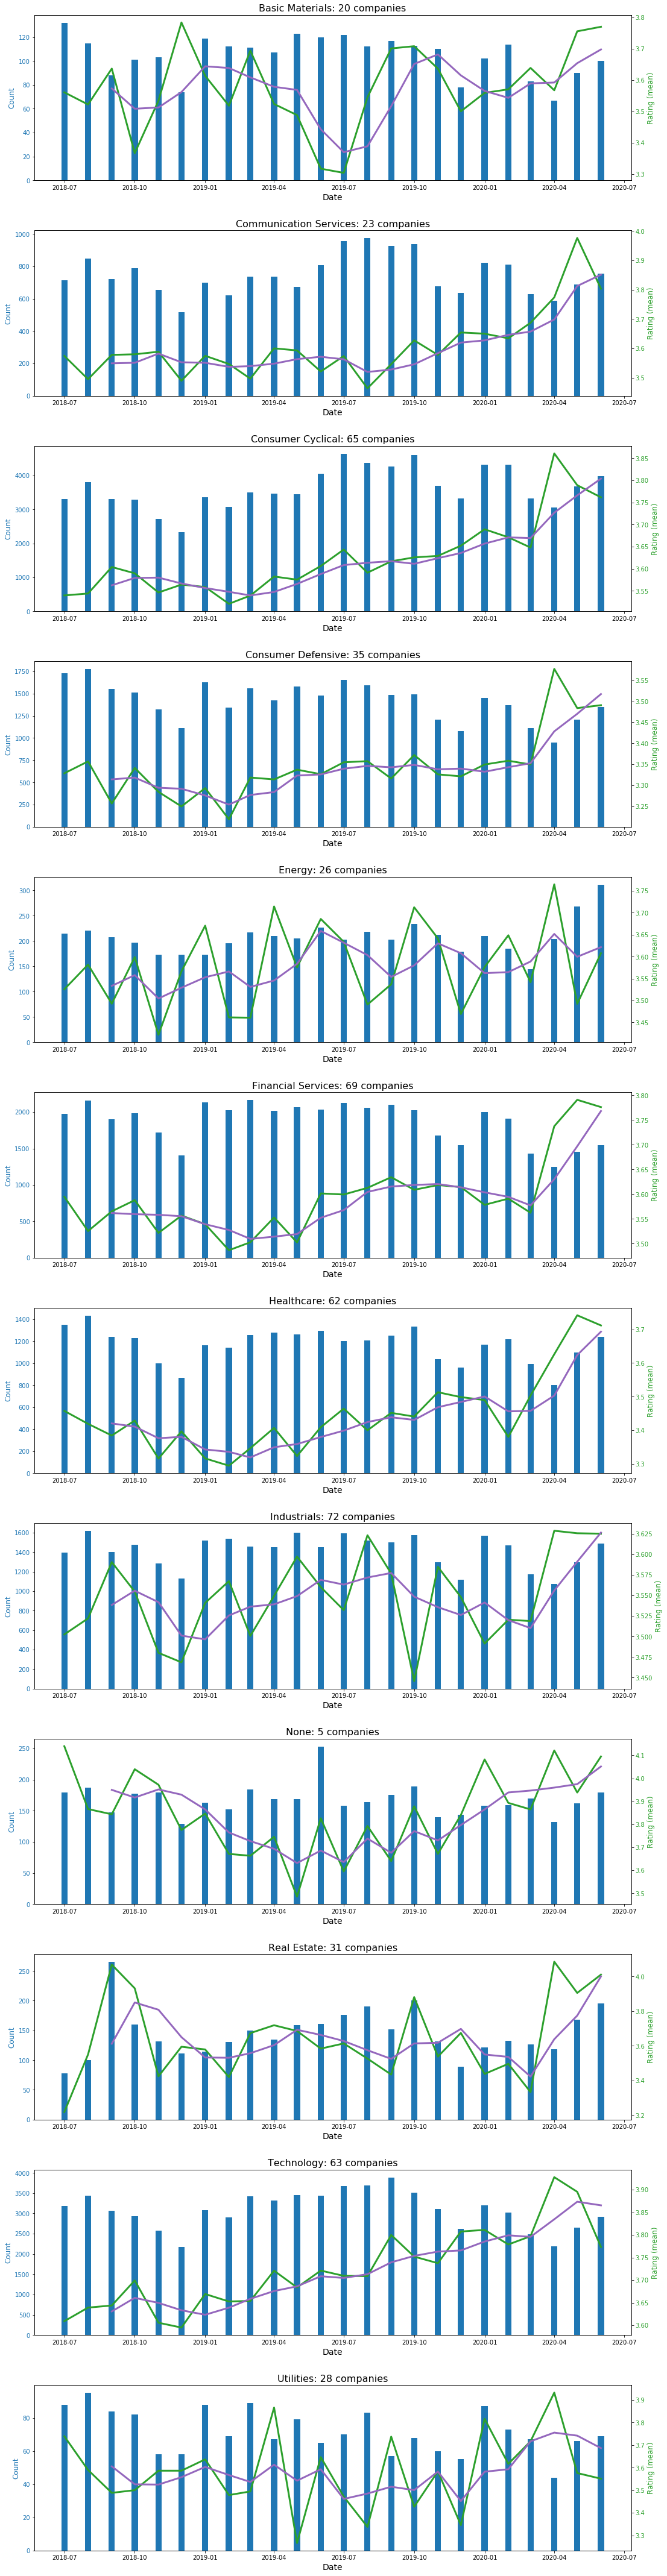

In [81]:
fig, axes = plt.subplots(len(sectors),1, figsize = (16,5*len(sectors) ))

for i, sector in enumerate(sectors):
    no_companies = companies[companies.Sector == sector].shape[0]
    
    axes[i].set_xlabel('Date', fontsize=14)
    axes[i].set_title(f'{sector}: {no_companies} companies', fontsize=16)

    color = 'tab:blue'
    axes[i].set_ylabel('Count', color=color, fontsize=12)  # we already handled the x-label with ax1
    axes[i].bar(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Count'],
        color=color,
        width=8
    )
    axes[i].tick_params(axis='y', labelcolor=color)

    ax2 = axes[i].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'

    ax2.set_ylabel('Rating (mean)', color=color, fontsize=12)
    ax2.plot(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Rating'],
        color=color,
        linewidth=3
    )
    ax2.plot(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['3M_Average'],
        color='tab:purple',
        linewidth=3
    )
    ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout(pad=3.0)

### 4.2 Change of mean rating - per month & sector

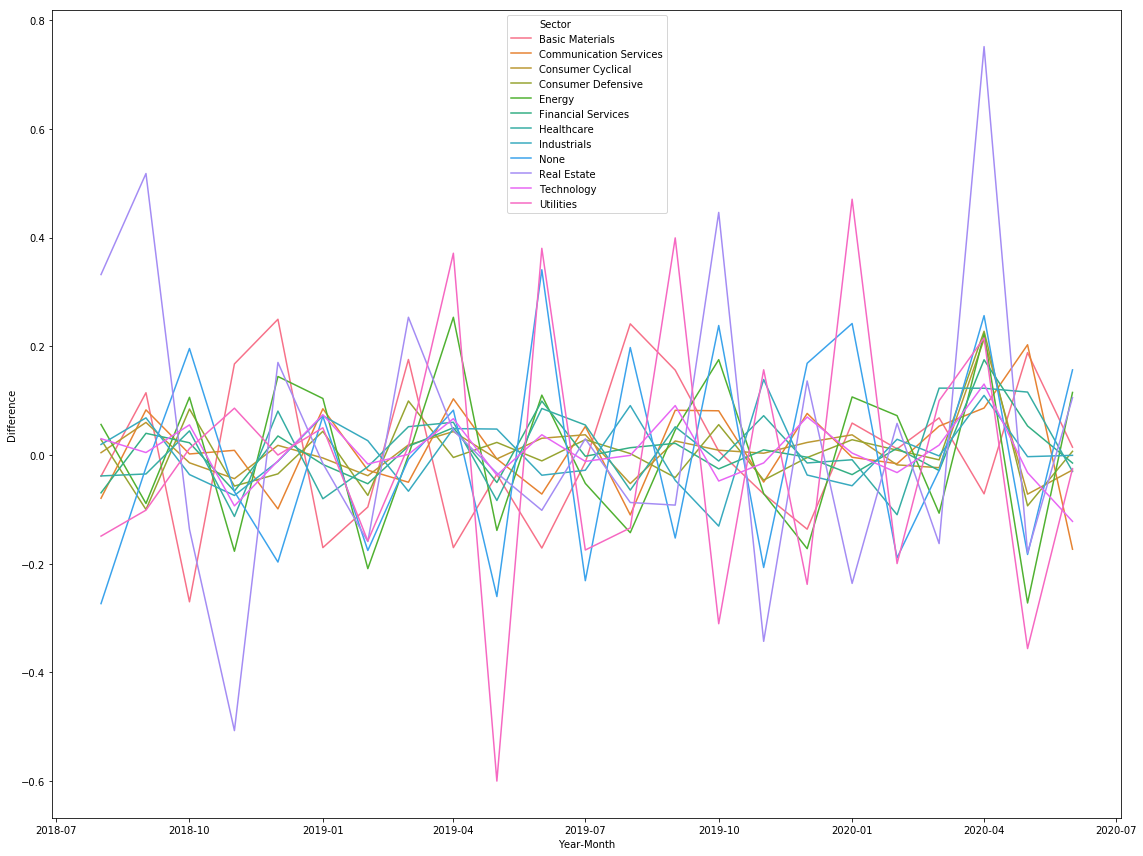

In [82]:
reviews_MonthSector['Difference'] = 0
i=0

for sector in sectors:
    diff = np.array(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Rating'].diff()
    )
    start = i
    end = i+diff.shape[0]
    
    reviews_MonthSector.iloc[i:end, -1] = diff
    i += diff.shape[0]
    
plt.figure(figsize = (16,12))
sns.lineplot('Year-Month', 'Difference', data = reviews_MonthSector, hue = 'Sector')
plt.tight_layout()

## 5. Reviews-Employees ratio

In [85]:
companies['ReviewsRatio'] = companies.TotalReviews / companies.NoEmployees
companies[['Company', 'ReviewsRatio', 'TotalReviews']].sort_values(by='ReviewsRatio', ascending=False)

,Company,ReviewsRatio,TotalReviews
119,Conagra Brands,inf,150
406,Salesforce.com,inf,2100
22,Allstate Corp,inf,1180
207,General Dynamics,inf,80
338,Nike,inf,1290
...,...,...,...
167,Emerson Electric Company,0.0,0
168,Entergy Corp.,0.0,0
169,EOG Resources,0.0,0
335,News Corp. Class B,0.0,0


In [90]:
# Now we remove bottom decile companies and those with one reviews per mont
companies_selected = companies[companies.TotalReviews>10]

bottom_decile = companies.ReviewsRatio.quantile(0.1)
companies_selected = companies_selected[companies_selected.ReviewsRatio > bottom_decile]

In [92]:
reviews_selected = reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
reviews_selected = reviews_selected[reviews_selected.Company_id.isin(list(companies_selected.id))]

In [117]:
def sentiment_monthly(sector, df=reviews_selected):
    reviews = reviews_selected[df.Sector == sector]
    
    monthly_rating = pd.DataFrame(reviews
                      .groupby(['Company', 'Year-Month'])
                      .mean()
                      .Rating
                     )
    
    data = pd.DataFrame(monthly_rating.to_records())
    
    return pd.pivot_table(
        data=data, values='Rating', index='Company', columns='Year-Month'
    )

In [105]:
pd.set_option('display.max_columns', None)

### 5.1 Basic materials

In [118]:
sentiment_monthly('Basic Materials')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
Air Products & Chemicals Inc,4.000000,3.181818,4.000000,4.000000,3.333333,NaN,4.600000,4.000000,3.833333,3.750000,3.750000,4.666667,4.000000,4.333333,3.666667,3.500000,3.600000,5.000000,4.000000,4.000000,4.200000,3.000000,4.333333,4.000000
Albemarle Corp,3.750000,5.000000,3.666667,4.000000,4.000000,4.000000,5.000000,NaN,NaN,1.500000,3.333333,NaN,4.000000,3.000000,3.000000,NaN,4.000000,NaN,5.000000,2.500000,NaN,NaN,4.000000,3.500000
CF Industries Holdings Inc,3.000000,NaN,5.000000,1.000000,4.500000,NaN,5.000000,5.000000,NaN,4.000000,2.000000,NaN,NaN,3.500000,NaN,3.333333,1.000000,NaN,1.000000,3.000000,NaN,NaN,2.000000,4.000000
Celanese,5.000000,4.000000,4.000000,NaN,4.500000,2.000000,NaN,3.000000,5.000000,5.000000,2.400000,2.000000,3.500000,4.000000,NaN,4.000000,5.000000,NaN,5.000000,4.000000,5.000000,4.000000,4.250000,4.333333
Corteva,NaN,NaN,NaN,NaN,1.000000,4.000000,3.000000,4.000000,4.000000,2.500000,3.153846,3.100000,3.375000,2.888889,4.750000,4.000000,3.600000,3.250000,3.333333,3.500000,4.285714,2.333333,3.833333,4.666667
Dow Inc.,3.473684,3.500000,3.909091,3.692308,3.500000,4.250000,4.000000,3.312500,3.611111,3.833333,4.047619,3.611111,3.714286,3.666667,3.125000,3.500000,3.947368,3.785714,3.785714,3.466667,3.909091,3.714286,3.923077,4.142857
Eastman Chemical,4.533333,3.900000,4.181818,4.714286,3.714286,4.000000,3.900000,4.500000,4.000000,3.357143,2.600000,2.666667,2.600000,3.230769,3.333333,3.555556,4.500000,2.000000,3.000000,3.333333,3.000000,4.000000,4.500000,3.666667
FMC Corporation,3.000000,NaN,5.000000,4.333333,2.666667,4.000000,4.250000,NaN,3.000000,1.500000,5.000000,3.000000,3.333333,3.250000,5.000000,2.666667,4.000000,4.000000,5.000000,4.000000,2.000000,NaN,4.400000,4.000000
Freeport-McMoRan Inc.,5.000000,4.142857,4.000000,3.333333,4.000000,4.000000,3.250000,3.600000,3.833333,5.000000,4.000000,4.000000,5.000000,4.333333,4.200000,4.333333,3.200000,4.250000,4.000000,4.500000,3.500000,4.333333,4.333333,4.400000


### 5.2 Communication services

In [119]:
sentiment_monthly('Communication Services')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
AT&T Inc.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.190000,3.317757,3.205128,3.370000,3.362694,3.382550,3.266129,3.280702,3.279762,3.596639,3.372340,3.576471,3.349206
Activision Blizzard,5.000000,3.000000,NaN,1.000000,5.000000,5.000000,NaN,3.000000,4.000000,1.000000,NaN,4.000000,4.000000,NaN,NaN,1.500000,NaN,3.000000,4.000000,4.000000,2.000000,NaN,3.333333,2.666667
Alphabet Inc.,4.444444,4.310924,4.398148,4.214286,4.459184,4.656250,4.346774,4.524272,4.344828,4.387097,4.135338,4.348485,4.544118,4.406504,4.431818,4.474026,4.286957,4.482759,4.382166,4.525926,4.546875,4.482517,4.449704,4.450000
CenturyLink Inc,2.940299,3.028169,3.104167,3.098039,2.777778,2.531250,2.781250,2.810345,2.764706,3.020408,3.000000,2.807692,2.658537,2.920000,2.854167,3.000000,2.969697,3.129032,2.948718,3.074074,2.942857,2.884615,3.264706,3.069767
Charter Communications,3.204082,2.783333,2.956522,3.102041,3.225000,3.054054,2.760870,2.705128,3.090090,2.709091,2.813084,2.934579,2.907563,2.792000,2.652542,2.827273,3.105263,2.810345,2.967742,2.978261,2.424658,2.510638,3.078125,3.157895
Comcast Corp.,3.529412,3.266667,3.365591,3.432099,3.342466,3.289855,3.495327,3.257576,3.355263,3.512500,3.475000,3.194030,3.340206,3.337349,3.560976,3.738636,3.327869,3.600000,3.500000,3.342105,3.294118,3.459459,3.928571,4.000000
"Discovery, Inc.",3.157895,3.777778,3.692308,3.076923,3.333333,3.000000,2.916667,3.250000,3.545455,3.300000,3.800000,3.700000,3.800000,3.666667,4.000000,3.500000,3.200000,3.500000,3.222222,2.666667,3.125000,4.000000,2.666667,3.666667
Dish Network,2.812500,3.212766,2.766667,3.277778,2.848485,2.722222,2.774194,2.227273,2.272727,2.280000,3.473684,3.054054,2.645161,2.411765,3.083333,2.894737,2.285714,3.366667,3.041667,2.642857,3.047619,2.100000,2.411765,2.878788
"Facebook, Inc.",4.666667,4.333333,4.428571,4.086957,4.047619,3.647059,4.833333,4.346154,4.000000,4.185185,4.117647,4.650000,4.611111,4.166667,4.250000,4.631579,4.400000,3.941176,4.652174,4.361111,4.212121,4.555556,4.695652,4.500000


### 5.3 Consumer Cyclical

In [120]:
sentiment_monthly('Consumer Cyclical')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
Advance Auto Parts,3.086957,3.200000,3.040000,3.478261,3.259259,3.222222,3.611111,3.190476,2.750000,3.222222,3.176471,2.882353,2.954545,3.375000,3.000000,3.090909,2.125000,2.571429,3.370370,2.727273,3.454545,2.866667,3.538462,2.933333
Amazon.com Inc.,3.634111,3.629442,3.803596,3.779150,3.663283,3.717131,3.805136,3.715266,3.775687,3.838109,3.832624,3.864615,3.908981,3.747804,3.792208,3.773402,3.777778,3.865607,3.936905,3.877386,3.788536,3.990021,3.871681,3.909468
Amcor plc,2.500000,3.250000,2.000000,3.714286,2.600000,3.666667,2.666667,3.000000,3.000000,4.000000,NaN,2.500000,3.375000,3.142857,3.181818,3.142857,3.000000,2.857143,2.875000,4.222222,2.900000,3.875000,4.000000,3.500000
AutoZone Inc,3.379310,2.818182,3.290323,3.000000,3.125000,2.681818,3.324324,2.931034,3.181818,2.470588,2.695652,2.823529,2.838710,3.380952,3.185185,3.138889,3.272727,3.176471,2.695652,3.575758,3.307692,2.666667,2.862069,2.777778
Ball Corp,3.000000,2.166667,3.000000,2.666667,2.600000,1.000000,2.000000,NaN,3.000000,3.428571,3.000000,3.000000,4.000000,3.000000,3.500000,3.500000,4.000000,5.000000,3.333333,3.000000,4.000000,4.500000,4.500000,4.000000
Best Buy Co. Inc.,3.582857,3.707447,3.664740,3.837079,3.727891,3.752212,3.712871,3.697531,3.524862,3.702703,3.674419,3.844828,3.778409,3.621762,3.806122,3.747312,3.765152,3.883929,3.762712,3.804469,3.640000,3.880435,4.015748,4.027397
BorgWarner,3.333333,4.333333,3.000000,3.500000,2.400000,5.000000,4.200000,2.250000,3.500000,3.000000,4.666667,3.000000,3.200000,NaN,3.500000,3.666667,3.000000,3.000000,3.666667,2.500000,3.000000,3.600000,3.666667,4.333333
Carmax Inc,3.307692,4.000000,3.225000,3.200000,3.472222,3.533333,3.400000,3.375000,3.477273,3.235294,3.707317,3.441176,3.464286,2.818182,3.333333,3.358974,2.931034,3.090909,3.184211,3.195122,3.400000,3.789474,3.440000,3.772727
Chipotle Mexican Grill,3.344828,3.381443,3.442308,3.361111,3.418919,3.433962,3.333333,3.443182,3.283951,3.363636,3.253165,3.458333,3.318182,3.250000,3.447059,3.255556,3.373134,3.812500,3.439024,3.487179,3.355932,3.595745,3.500000,3.461538


### 5.4 Consumer Defensive

In [121]:
sentiment_monthly('Consumer Defensive')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
Altria Group Inc,2.142857,3.571429,4.428571,5.000000,4.250000,3.333333,3.785714,3.461538,3.200000,4.666667,3.875000,3.142857,3.000000,4.000000,4.000000,3.333333,3.428571,5.000000,3.000000,3.000000,1.000000,NaN,3.250000,3.142857
Archer-Daniels-Midland Co,3.500000,3.200000,3.300000,3.444444,3.333333,3.375000,2.888889,3.500000,3.500000,2.750000,4.000000,2.777778,3.800000,3.437500,3.142857,3.444444,3.500000,3.250000,4.166667,4.000000,4.000000,2.666667,3.571429,1.666667
Campbell Soup,3.285714,3.666667,3.000000,2.777778,3.857143,3.750000,3.200000,2.250000,3.000000,2.666667,3.625000,3.500000,3.000000,3.750000,3.500000,2.750000,3.000000,2.666667,4.000000,3.285714,3.000000,3.200000,3.833333,3.750000
Church & Dwight,4.000000,NaN,2.000000,5.000000,4.000000,4.000000,5.000000,2.800000,3.000000,2.250000,3.000000,NaN,3.500000,4.500000,NaN,4.000000,5.000000,3.750000,2.750000,1.666667,NaN,2.666667,4.000000,2.500000
Coca-Cola Company,3.890909,3.568182,3.793103,3.727273,3.566667,3.500000,3.666667,3.724138,3.641026,3.709677,3.729167,3.965517,3.825000,3.840909,3.844444,3.594595,3.653846,3.909091,4.030303,3.322581,3.838710,4.000000,3.968750,3.971429
Colgate-Palmolive,3.866667,4.000000,3.833333,3.588235,3.700000,3.750000,3.538462,4.222222,3.111111,4.100000,3.916667,4.000000,4.047619,3.916667,4.227273,4.090909,4.090909,4.111111,4.000000,3.800000,3.666667,4.375000,3.750000,4.428571
Conagra Brands,2.750000,3.571429,3.000000,2.166667,4.333333,4.000000,2.500000,3.750000,3.200000,2.857143,3.800000,3.000000,3.666667,3.500000,3.857143,3.500000,2.833333,3.400000,3.875000,3.454545,4.111111,4.000000,4.500000,3.250000
Constellation Brands,2.400000,2.333333,3.000000,2.500000,2.000000,2.666667,2.285714,3.857143,2.500000,4.500000,3.166667,2.714286,3.000000,2.250000,1.000000,3.500000,3.750000,4.000000,3.666667,2.000000,2.000000,3.000000,3.000000,NaN
Costco Wholesale Corp.,4.086207,4.067568,3.849315,3.912500,3.868852,4.046154,3.972973,4.018519,3.920455,3.925373,3.876712,3.974359,4.136364,3.974684,3.955224,3.888889,3.540984,4.107143,3.902439,3.784615,3.696429,4.272727,4.054545,4.271186


### 5.5 Energy

In [122]:
sentiment_monthly('Energy')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
Apache Corporation,3.500000,2.750000,NaN,3.000000,3.800000,5.000000,NaN,3.500000,5.000000,4.000000,4.000000,3.666667,3.666667,3.500000,4.500000,3.500000,4.000000,4.333333,4.000000,2.666667,3.500000,3.333333,2.500000,3.000000
Baker Hughes Co,3.500000,3.333333,3.380952,3.640000,3.600000,3.235294,3.482759,3.500000,3.793103,3.545455,3.904762,3.333333,3.692308,3.500000,4.037037,4.045455,3.625000,3.640000,3.277778,3.538462,3.230769,3.828571,3.000000,3.500000
Chevron Corp.,3.560000,4.277778,4.040000,3.909091,3.777778,3.636364,4.217391,4.125000,4.000000,4.333333,4.000000,4.307692,3.925926,3.956522,3.590909,4.200000,4.285714,3.923077,4.294118,4.105263,4.272727,4.222222,4.130435,4.125000
Concho Resources,NaN,5.000000,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,1.750000,5.000000,1.500000,NaN,NaN,NaN,NaN,3.500000,NaN
ConocoPhillips,4.200000,3.600000,3.666667,3.666667,4.000000,4.111111,4.500000,4.750000,4.400000,4.285714,4.500000,4.666667,3.500000,3.666667,4.000000,4.666667,4.500000,3.500000,3.750000,5.000000,4.333333,3.500000,3.400000,4.500000
Devon Energy,NaN,2.000000,3.166667,3.000000,3.666667,3.500000,2.500000,4.500000,3.500000,3.600000,3.000000,4.800000,4.000000,4.285714,2.500000,3.200000,3.666667,4.000000,4.200000,NaN,NaN,2.500000,3.000000,3.333333
Exxon Mobil Corp.,3.941176,4.071429,3.800000,3.333333,4.000000,2.800000,3.400000,3.714286,3.250000,3.636364,3.375000,3.375000,4.250000,2.833333,4.250000,3.800000,1.750000,3.714286,3.333333,3.800000,3.333333,3.545455,4.142857,3.636364
Halliburton Co.,3.593750,3.600000,3.217391,3.689655,3.173913,3.500000,3.833333,3.750000,3.291667,3.515152,3.259259,3.387097,3.346154,3.500000,3.321429,3.488372,3.454545,3.206897,3.250000,3.542857,3.357143,3.783784,3.491228,3.318182
Hess Corporation,NaN,4.500000,4.000000,4.500000,2.000000,3.500000,NaN,4.000000,4.000000,4.333333,4.500000,3.800000,NaN,NaN,3.750000,4.000000,4.000000,3.000000,3.333333,NaN,2.000000,5.000000,2.500000,4.000000


### 5.6 Financial Services

In [123]:
sentiment_monthly('Financial Services')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
AFLAC Inc,3.333333,3.384615,3.000000,3.111111,3.750000,2.333333,3.153846,3.500000,3.000000,2.666667,3.000000,3.800000,2.500000,4.000000,4.062500,3.714286,3.714286,4.000000,3.636364,3.888889,3.000000,3.750000,4.250000,3.500000
Alliance Data Systems,3.521739,3.166667,4.000000,3.666667,3.666667,3.500000,4.333333,3.333333,2.750000,3.100000,2.857143,3.000000,3.666667,2.375000,3.714286,2.142857,3.250000,2.875000,2.428571,3.000000,2.625000,3.000000,3.500000,4.000000
American Express Co,3.888889,3.681319,3.736111,4.169492,3.785714,4.275000,3.933333,3.680556,3.957447,4.076923,4.000000,3.912500,4.000000,4.014493,4.080460,4.157303,4.073171,4.000000,3.960526,4.027397,4.293103,4.482143,4.272727,3.980769
American International Group,3.418605,3.196078,3.244444,3.055556,3.173913,3.033333,2.958333,2.704545,2.912281,3.282609,3.238095,3.073171,3.153846,3.500000,3.282051,3.333333,3.050000,3.296296,3.280000,3.236842,2.791667,3.352941,3.454545,3.451613
Ameriprise Financial,3.619048,3.166667,3.500000,3.000000,3.875000,3.769231,3.875000,3.933333,4.222222,3.416667,3.700000,3.052632,3.950000,3.210526,3.428571,4.055556,3.153846,3.888889,3.500000,2.800000,3.200000,3.846154,4.066667,3.555556
Aon plc,3.281250,3.333333,3.717949,3.622222,3.243902,3.428571,3.428571,3.266667,3.535714,3.547170,3.355556,3.637931,3.687500,3.456522,3.622222,3.531915,3.777778,3.600000,3.622222,3.617647,3.518519,3.370370,3.250000,3.387097
Arthur J. Gallagher & Co.,2.846154,2.818182,3.176471,3.411765,2.705882,2.666667,2.529412,3.470588,2.631579,3.157895,2.958333,2.588235,3.259259,3.421053,3.000000,3.000000,3.000000,3.300000,3.333333,3.040000,2.666667,2.916667,3.461538,3.125000
Assurant,3.307692,3.352941,3.500000,2.722222,2.900000,2.727273,3.428571,3.277778,2.600000,3.384615,2.900000,3.250000,3.222222,3.428571,3.400000,3.562500,2.875000,3.428571,3.500000,3.666667,3.600000,4.200000,3.100000,3.333333
Bank of America Corp,3.641304,3.500000,3.610063,3.638614,3.549669,3.407080,3.672619,3.461538,3.602564,3.567416,3.619632,3.610778,3.483871,3.661458,3.637931,3.704698,3.733813,3.611511,3.635714,3.526316,3.757812,3.650000,3.731959,4.019048


### 5.7 Healthcare

In [124]:
sentiment_monthly('Healthcare')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
ABIOMED Inc,3.000000,3.750000,4.666667,1.000000,3.500000,NaN,3.000000,NaN,5.000000,1.000000,2.000000,1.666667,4.000000,5.000000,4.333333,2.666667,2.000000,5.000000,4.000000,5.000000,3.500000,3.500000,5.000000,3.000000
AbbVie Inc.,3.857143,3.000000,3.583333,4.071429,3.400000,3.750000,4.000000,3.733333,3.714286,3.500000,3.600000,4.000000,4.071429,4.333333,3.222222,3.400000,3.166667,2.750000,3.142857,3.777778,3.941176,3.100000,4.000000,4.388889
Abbott Laboratories,3.323529,3.666667,3.583333,3.323529,3.666667,3.583333,3.310345,3.290323,3.743590,3.300000,3.500000,3.586957,3.956522,2.944444,2.947368,3.604167,3.375000,3.736842,3.606061,3.228571,3.583333,4.250000,3.709677,3.785714
Agilent Technologies Inc,3.222222,3.750000,4.125000,3.909091,3.800000,3.545455,4.571429,3.900000,4.000000,4.133333,4.375000,4.133333,4.222222,3.428571,3.533333,4.000000,4.133333,4.500000,4.428571,3.875000,3.555556,3.700000,3.625000,4.500000
Alexion Pharmaceuticals,NaN,4.000000,1.500000,3.250000,NaN,3.000000,4.000000,2.000000,3.000000,NaN,1.500000,1.500000,2.500000,2.000000,NaN,2.333333,NaN,5.000000,5.000000,1.000000,NaN,4.500000,4.000000,NaN
Align Technology,3.166667,3.200000,2.400000,1.500000,3.200000,1.000000,2.500000,3.000000,2.857143,4.000000,4.250000,4.500000,4.250000,3.857143,4.333333,4.333333,4.142857,4.357143,4.000000,4.428571,4.500000,4.529412,4.848485,4.380952
AmerisourceBergen Corp,2.666667,3.333333,3.000000,2.833333,2.000000,3.692308,3.166667,1.833333,2.727273,2.461538,2.200000,3.214286,3.076923,2.800000,2.666667,3.125000,3.300000,3.875000,2.666667,3.800000,2.000000,3.200000,3.666667,4.000000
Amgen Inc.,3.727273,4.000000,4.200000,3.818182,3.600000,3.500000,3.200000,3.187500,3.400000,2.428571,3.500000,3.470588,3.526316,3.285714,4.083333,3.533333,4.000000,3.636364,3.500000,3.625000,3.777778,4.083333,3.666667,3.642857
Anthem,4.236559,3.897436,3.512821,3.321429,3.520000,2.956522,3.041667,3.232558,3.500000,2.666667,2.735294,2.636364,3.392857,3.096774,3.230769,3.138889,3.555556,3.115385,3.153846,2.888889,3.233333,3.636364,3.000000,3.555556


### 5.8 Industrials

In [126]:
sentiment_monthly('Industrials')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
A.O. Smith Corp,NaN,3.333333,4.000000,5.000000,NaN,1.000000,3.000000,4.666667,3.250000,4.000000,5.000000,NaN,3.600000,3.333333,NaN,1.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,NaN,1.000000
AMETEK Inc.,4.000000,2.500000,2.500000,3.500000,4.166667,4.000000,NaN,3.600000,2.500000,5.000000,3.000000,NaN,2.333333,3.600000,2.000000,1.500000,3.250000,2.833333,1.000000,1.666667,2.000000,3.000000,2.250000,2.000000
Alaska Air Group Inc,3.750000,3.200000,4.000000,3.428571,3.666667,3.555556,3.555556,4.666667,2.800000,3.300000,3.571429,3.600000,3.500000,3.333333,4.000000,3.125000,3.833333,3.500000,3.857143,4.142857,3.750000,3.500000,4.100000,3.727273
Allegion,3.625000,4.200000,3.250000,3.400000,2.666667,3.250000,3.666667,3.250000,2.714286,1.000000,3.500000,4.666667,3.000000,4.400000,3.400000,2.666667,2.800000,4.000000,3.000000,3.000000,3.333333,2.857143,3.500000,2.000000
American Airlines Group,3.538462,3.966667,3.888889,3.636364,3.702703,3.565217,3.804878,3.928571,3.592593,3.575758,3.434783,4.035714,3.351351,3.500000,3.647059,3.310345,3.789474,3.333333,3.948718,3.536585,3.904762,3.500000,4.320000,3.653061
Automatic Data Processing,3.403846,3.716667,3.681529,3.826733,3.510638,3.514286,3.689655,4.124481,3.617021,3.612903,3.843137,3.527273,3.457364,3.343750,3.520408,3.326316,3.551282,3.870588,3.382609,3.525773,3.732558,4.030303,3.941176,3.957447
Avery Dennison Corp,3.714286,2.714286,2.333333,3.750000,4.166667,3.166667,4.000000,3.600000,2.800000,3.750000,3.250000,3.333333,3.571429,3.000000,4.000000,3.923077,3.666667,4.142857,3.500000,3.625000,3.666667,4.500000,4.333333,3.250000
Boeing Company,3.687500,3.422535,3.578125,3.617021,3.659574,3.658537,3.722222,3.490566,3.644444,3.672414,3.705882,3.274510,3.522727,3.581081,3.702128,3.696429,3.712121,3.784314,3.400000,3.666667,3.557692,3.693548,3.658824,3.937500
C. H. Robinson Worldwide,3.352941,3.000000,3.833333,3.300000,3.600000,3.363636,3.076923,2.937500,3.142857,3.333333,3.285714,3.181818,3.722222,3.100000,3.360000,3.185185,2.769231,3.600000,3.368421,3.520000,3.357143,3.833333,3.000000,2.833333


### 5.9 Real Estate

In [127]:
sentiment_monthly('Real Estate')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
Alexandria Real Estate Equities,NaN,1.000000,NaN,NaN,NaN,5.000000,NaN,2.000000,NaN,3.000000,NaN,1.000000,NaN,5.000000,NaN,NaN,3.000000,5.000000,NaN,NaN,4.000000,2.000000,NaN,NaN
American Tower Corp.,4.250000,4.500000,3.285714,3.666667,1.500000,3.000000,2.750000,3.000000,3.833333,4.666667,2.333333,5.000000,3.333333,2.250000,2.250000,3.500000,2.500000,2.500000,3.200000,2.666667,3.500000,4.000000,3.250000,2.800000
AvalonBay Communities,4.500000,4.333333,4.388889,4.714286,4.500000,4.666667,3.777778,4.250000,3.800000,4.200000,4.666667,4.636364,4.142857,4.285714,4.166667,4.576923,2.000000,3.800000,3.666667,3.500000,3.600000,4.500000,2.600000,4.500000
Boston Properties,1.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,3.333333,NaN,NaN,5.000000,3.000000,4.000000,3.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
CBRE Group,NaN,3.666667,3.392157,3.849057,3.714286,3.731707,3.739130,3.796296,3.769231,3.701754,3.660000,3.529412,3.285714,3.434211,3.634921,3.534247,3.690909,3.833333,3.581395,3.418605,3.522727,3.825000,3.681818,3.879310
Crown Castle International Corp.,4.000000,3.700000,4.833333,4.000000,4.250000,3.750000,3.571429,3.714286,3.666667,2.500000,3.000000,3.000000,3.250000,3.800000,4.125000,3.400000,1.800000,3.000000,4.000000,3.000000,5.000000,NaN,4.500000,1.000000
Digital Realty Trust Inc,2.000000,3.600000,4.500000,5.000000,4.666667,4.000000,3.000000,4.500000,4.000000,4.000000,4.684211,4.000000,2.000000,5.000000,4.666667,3.500000,5.000000,5.000000,4.000000,4.500000,3.000000,5.000000,3.500000,3.500000
Equinix,3.600000,3.600000,3.777778,4.000000,2.666667,2.769231,3.285714,2.666667,3.636364,4.400000,4.000000,4.100000,4.400000,4.285714,3.875000,3.384615,3.333333,2.750000,4.200000,4.200000,3.571429,3.333333,4.000000,3.875000
Equity Residential,5.000000,3.500000,4.400000,3.600000,4.500000,4.200000,5.000000,3.666667,3.875000,5.000000,4.571429,2.571429,4.000000,4.307692,3.166667,4.545455,4.545455,4.000000,4.454545,3.222222,1.666667,5.000000,3.333333,5.000000


### 5.10 Technology

In [128]:
sentiment_monthly('Technology')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
ANSYS,3.500000,4.333333,4.333333,4.666667,5.000000,3.666667,4.000000,4.666667,4.500000,3.500000,3.666667,3.875000,4.200000,3.750000,4.250000,3.800000,NaN,2.666667,4.000000,1.333333,3.666667,3.000000,4.250000,3.000000
Adobe Inc.,3.750000,4.375000,3.333333,4.200000,4.692308,4.454545,4.153846,3.222222,3.909091,4.181818,4.214286,4.250000,4.142857,4.312500,3.750000,4.500000,3.800000,4.400000,3.583333,4.000000,4.000000,3.800000,4.000000,4.833333
Advanced Micro Devices Inc,3.812500,3.214286,3.846154,3.384615,4.111111,3.222222,3.785714,3.916667,4.214286,4.571429,4.090909,4.166667,4.000000,4.285714,4.055556,4.000000,4.142857,4.461538,3.866667,3.333333,3.857143,3.500000,4.000000,4.100000
Akamai Technologies Inc,3.916667,3.777778,3.869565,3.450000,3.714286,4.250000,3.733333,3.647059,4.125000,4.384615,3.900000,4.200000,3.500000,3.750000,4.000000,3.611111,4.428571,4.428571,3.833333,4.153846,2.500000,4.562500,4.214286,4.307692
"Analog Devices, Inc.",3.000000,3.285714,4.285714,4.142857,4.142857,3.666667,3.500000,3.000000,4.100000,4.500000,4.000000,3.714286,4.250000,3.285714,4.333333,4.111111,4.625000,3.833333,4.300000,4.125000,3.333333,3.142857,3.600000,4.333333
Apple Inc.,4.029940,4.067010,4.049689,4.021978,3.859155,3.961832,4.071856,4.006173,4.045918,4.081218,3.931579,4.031746,3.951087,3.806931,3.800000,4.087179,3.968153,4.077419,4.021858,4.247253,4.326667,4.231405,4.408163,4.243902
Applied Materials Inc.,3.722222,3.909091,3.071429,3.916667,3.785714,3.428571,3.692308,4.000000,3.333333,3.526316,3.700000,4.076923,3.800000,3.421053,3.615385,3.777778,2.764706,3.400000,3.888889,4.111111,4.200000,3.571429,3.545455,4.111111
Arista Networks,4.400000,4.000000,3.666667,3.666667,4.750000,NaN,4.500000,3.333333,3.285714,3.750000,3.750000,2.000000,3.666667,4.000000,2.900000,3.500000,4.200000,4.500000,3.625000,1.666667,4.000000,5.000000,3.571429,4.000000
Autodesk Inc.,3.764706,4.000000,3.809524,3.941176,3.736842,4.066667,4.034483,4.375000,4.238095,3.400000,3.833333,4.285714,4.041667,4.000000,4.071429,3.800000,4.277778,3.727273,3.733333,3.619048,3.705882,4.105263,3.666667,3.578947


### 5.11 Utilities

In [129]:
sentiment_monthly('Utilities')

Year-Month,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01
Company,,,,,,,,,,,,,,,,,,,,,,,,
AES Corp,4.142857,5.000000,2.500000,NaN,4.000000,4.357143,3.571429,3.666667,3.000000,3.000000,3.000000,3.000000,3.333333,4.666667,5.000000,1.333333,3.000000,5.000000,5.000000,4.714286,4.714286,5.000000,5.000000,4.142857
Alliant Energy Corp,5.000000,4.250000,4.000000,3.000000,4.000000,NaN,2.000000,4.000000,3.000000,4.500000,4.000000,5.000000,NaN,4.000000,5.000000,NaN,NaN,NaN,2.800000,1.000000,1.000000,5.000000,2.666667,2.600000
Ameren Corp,3.500000,4.333333,3.200000,4.000000,NaN,4.000000,2.500000,3.666667,1.000000,3.428571,3.200000,1.000000,NaN,5.000000,5.000000,3.800000,3.000000,3.500000,5.000000,4.500000,NaN,4.333333,5.000000,3.500000
American Electric Power,3.666667,4.000000,4.666667,3.333333,3.000000,NaN,4.333333,3.666667,3.500000,4.000000,2.666667,4.333333,3.000000,3.000000,4.666667,5.000000,3.500000,2.500000,4.000000,3.000000,3.333333,4.000000,3.500000,5.000000
American Water Works Company Inc,1.750000,2.500000,3.000000,1.500000,4.000000,4.000000,4.500000,2.750000,2.666667,3.000000,2.500000,3.000000,2.000000,2.500000,2.000000,5.000000,3.500000,2.000000,3.666667,2.000000,2.000000,3.000000,1.000000,NaN
Atmos Energy,4.666667,5.000000,NaN,4.333333,NaN,4.500000,5.000000,4.500000,3.000000,NaN,NaN,NaN,NaN,3.000000,4.000000,NaN,2.000000,3.666667,5.000000,1.000000,4.000000,5.000000,4.500000,5.000000
CMS Energy,4.500000,NaN,3.800000,4.000000,4.000000,NaN,3.500000,5.000000,5.000000,NaN,4.000000,3.000000,5.000000,NaN,NaN,NaN,3.000000,4.000000,5.000000,4.500000,5.000000,5.000000,4.000000,4.000000
CenterPoint Energy,3.000000,4.333333,4.000000,3.800000,3.500000,3.000000,5.000000,4.500000,3.166667,3.000000,3.400000,4.000000,4.250000,4.250000,4.666667,2.000000,3.000000,1.500000,4.250000,4.000000,3.000000,NaN,2.000000,NaN
Consolidated Edison,2.666667,4.166667,4.000000,5.000000,3.666667,1.666667,4.142857,4.000000,2.750000,4.090909,4.666667,3.714286,4.000000,3.428571,2.666667,3.333333,4.200000,3.250000,3.625000,3.333333,3.250000,3.333333,4.000000,5.000000
